In [5]:
import pandas as pd
import numpy as np
import datetime
import pickle
from dateutil import relativedelta
from sqlalchemy import create_engine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [6]:
# данные, полученные из модели машинного обучения
# по нескольким гипотезам со склада идей
df = pd.read_csv('search_results.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   search_for   247 non-null    object 
 1   article      247 non-null    int64  
 2   description  247 non-null    object 
 3   com_qty      247 non-null    float64
 4   sales        247 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 9.8+ KB


In [7]:
df.head(10)

,search_for,article,description,com_qty,sales
0,база под тени,2865742,"База под тени для век Eyeshadow Base, 5 мл.",3431.0,4283.0
1,база под тени,4992119,База под тени Eye Shadow Base / основа под тени,1393.0,3514.0
2,база под тени,4869336,База под тени для век I love colour intensifyi...,442.0,371.0
3,база под тени,12945408,"База под тени для век ""Luxury""",160.0,370.0
4,база под тени,35052839,База под макияж / Основа под макияж / Праймер ...,41.0,217.0
5,база под тени,16182750,База-основа под тени для век HD HIGH DEFINITIO...,1.0,214.0
6,база под тени,12139916,"База под тени серии EYE SHADOW BASE, 7мл",210.0,191.0
7,база под тени,14253785,База под тени для век Magique,42.0,102.0
8,база под тени,2094813,"База под тени для век ""Perfect Skin"", тон 20",836.0,63.0
9,база под тени,13641055,"Тени для век, палетка теней, макияж глаз и бро...",192.0,54.0


In [8]:
df[['search_for','com_qty','sales']].groupby(by=['search_for']).sum().reset_index()

,search_for,com_qty,sales
0,база под тени,6878.0,9453.0
1,банановая пудра,0.0,2.0
2,воск для рук,3223.0,4419.0
3,жидкие румяна,1802.0,653.0
4,косметический лед,43.0,130.0
5,крем с ацеролой,2.0,3.0
6,крио-маска для лица,1984.0,8075.0
7,липосомальная сыворотка,234.0,701.0
8,маска с матчей,232.0,647.0
9,скраб для губ,3314.0,7407.0


In [ ]:
# данные, полученные из модели машинного обучения
# sku из кластера
file = 'npd_market_research/df_good_clusters_sku.pickle'
with open(file, 'rb') as f:
    df_clusters = pickle.load(f)
df_clusters.head(10)

In [ ]:
df_clusters[['cluster','sku']].groupby('cluster').count().sort_values(by='sku', ascending=False).reset_index().head(10)

### Исследование рынка

In [9]:
# получаем список артикулов для поискового запроса
articles_list = [str(x) for x in df[df['search_for'] == 'скраб для губ']['article'].to_list()]
articles_list = set(articles_list)
articles_str = ",".join(articles_list)
len(articles_list)

119

##### или

In [ ]:
# получаем список артикулов из кластера
articles_list = [str(x) for x in df_clusters[df_clusters['cluster'] == 5859]['sku'].to_list()]
articles_list = set(articles_list)
articles_str = ",".join(articles_list)
len(articles_list)

In [11]:
# по указанным артикулам получаем данные mpstats за последние 6 мес.
date_1 = datetime.date.today() - relativedelta.relativedelta(months=6)
date_2 = datetime.date.today()

connection_string = ''
engine = create_engine(connection_string)

query = f"""
    select distinct
        mps_wb.mpstats_id as product_id,
        mps_wb."name" as "name",
        mps_wb.brand as brand,
        mps_wb.category as category,
        mps_wb."comments" as "comments",
        mps_wb.rating as rating,
        mps_wb.final_price as price,
        mps_wb.sales as sales_num,
        mps_wb."date" as "date"
    from sa.mps_wb_products as mps_wb
    where 1 = 1
        and mps_wb."date" between '{str(date_1)}' and '{str(date_2)}'
        and mps_wb.mpstats_id in ({articles_str})
    """
mpstats = pd.read_sql(query, engine)
engine.dispose()

In [12]:
mpstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14461 entries, 0 to 14460
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  14461 non-null  int64 
 1   name        14461 non-null  object
 2   brand       14461 non-null  object
 3   category    14461 non-null  object
 4   comments    14461 non-null  int64 
 5   rating      14461 non-null  int64 
 6   price       14461 non-null  int64 
 7   sales_num   14461 non-null  int64 
 8   date        14461 non-null  object
dtypes: int64(5), object(4)
memory usage: 1016.9+ KB


In [13]:
# оставляем только товары, у которых были продажи (решили с Кириллом)
mpstats = mpstats[mpstats['sales_num'] > 0].reset_index(drop=True)
len(mpstats)

6516

In [14]:
# удаляем дубликаты (особенность данных), без учета поля category
mpstats['product_id'] = mpstats['product_id'].astype(str)
mpstats = mpstats.drop_duplicates(subset=['product_id','category','date',], keep='last')
len(mpstats)

6516

In [15]:
mpstats.head(10)

,product_id,name,brand,category,comments,rating,price,sales_num,date
0,16597194,Скраб для бровей и губ Brow Scrub 100 мл,Zola,Красота/Уход за кожей/Уход за лицом/Скраб,6,3,995,1,2021-12-21
1,11942318,Подарочный набор Кокос: Кокосовое масло Экстра...,СпивакЪ,Красота/Уход за кожей/Уход за телом/Косметичес...,19,5,912,1,2022-02-05
2,2866055,Восстанавливающий крем после процедур лазерной...,Beauty Style,Красота/Уход за кожей/Уход за лицом/Крем,37,5,796,5,2021-12-21
3,11669880,Скраб для губ coconut kiss ухаживающий т.01,essence,Красота/Уход за кожей/Уход для губ/Скраб,277,5,285,34,2021-12-20
4,6595065,Скраб для губ Organic Wear Organic Rose Oil Li...,Physicians Formula,Красота/Уход за кожей/Уход для губ/Скраб,67,4,454,3,2022-02-22
5,11990863,Малиновый скраб для губ,KOROLKOVA,Красота/Уход за кожей/Уход для губ/Скраб,10,5,475,1,2021-10-10
6,6595065,Скраб для губ Organic Wear Organic Rose Oil Li...,Physicians Formula,Красота/Уход за кожей/Уход для губ/Скраб,67,4,454,3,2022-01-25
7,11942315,"Подарочный набор для губ Ваниль: Помада, Бальз...",СпивакЪ,Красота/Уход за кожей/Уход за лицом/Косметичес...,29,5,513,1,2021-12-30
8,10725065,Скраб для губ Sugar baby,Neo Care,Красота/Уход за кожей/Уход за лицом/Скраб,73,3,148,1,2021-11-22
9,7893017,"Скраб для губ Бергамот, 15 г",СпивакЪ,Красота/Уход за кожей/Уход для губ/Скраб,238,5,170,1,2021-12-23


In [16]:
mpstats['category'].value_counts(normalize=True).head(20)  # наиболее популярные категории (справочно)

Красота/Уход за кожей/Уход для губ/Скраб                             0.462554
Красота/Уход за кожей/Уход за лицом/Скраб                            0.110651
Красота/Органическая косметика/Скраб                                 0.079343
Красота/Профессиональная косметика/Скраб                             0.049417
Красота/Уход за кожей/Уход за телом/Скраб                            0.035912
Красота/Уход за кожей/Уход для губ/Косметический набор для ухода     0.024862
Красота/Уход за кожей/Уход за лицом/Крем                             0.022406
Красота/Корейские бренды/Крем                                        0.022406
Красота/Мужская линия/Уход за лицом и телом/Скраб                    0.019797
Красота/Уход за кожей/Уход за лицом/Косметический набор для ухода    0.018723
Красота/Уход за кожей/Уход за ногами/Крем                            0.018416
Красота/Профессиональная косметика/Бальзам                           0.017649
Красота/Подарочные наборы/Косметический набор для ухода         

In [17]:
mpstats = mpstats.rename(columns={'category':'category_init'})
mpstats['category'] = [x.split('/') for x in mpstats['category_init']]
mpstats['subject'] = [x[-1] for x in mpstats['category']]  # тип товаров
mpstats['category'] = [x[0] for x in mpstats['category']]
mpstats['subject'].value_counts(normalize=True).head(10)

Скраб                            0.773941
Косметический набор для ухода    0.077502
Крем                             0.063229
Бальзам                          0.033610
Маска косметическая              0.011357
Гель                             0.010589
Сыворотка                        0.009208
Уход для губ                     0.006139
Блеск                            0.005832
Уход за лицом                    0.002762
Name: subject, dtype: float64

In [13]:
import numpy as np
import pandas as pd

a = np.NaN
if pd.notna(a):
    print('a')

In [18]:
# выбранные категории
sorted(mpstats[mpstats['subject'] == mpstats['subject'].value_counts().index[0]]['category_init'].unique().tolist())

['Красота/Аптечная косметика/Скраб',
 'Красота/Волосы/Уход за волосами/Скраб',
 'Красота/Корейские бренды/Скраб',
 'Красота/Мужская линия/Уход за лицом и телом/Скраб',
 'Красота/Органическая косметика/Скраб',
 'Красота/Профессиональная косметика/Скраб',
 'Красота/Уход за кожей/Для ванны и душа/Скраб',
 'Красота/Уход за кожей/Уход для губ/Скраб',
 'Красота/Уход за кожей/Уход за лицом/Скраб',
 'Красота/Уход за кожей/Уход за руками/Скраб',
 'Красота/Уход за кожей/Уход за телом/Скраб']

In [19]:
# прочие категории
sorted(mpstats[~(mpstats['subject'] == mpstats['subject'].value_counts().index[0])]['category_init'].unique().tolist())

['Красота/Аксессуары/Косметические принадлежности/Массажер косметический',
 'Красота/Корейские бренды',
 'Красота/Корейские бренды/Крем',
 'Красота/Корейские бренды/Сыворотка',
 'Красота/Макияж/Губы',
 'Красота/Макияж/Губы/Блеск',
 'Красота/Мужская линия/Уход за лицом и телом',
 'Красота/Органическая косметика',
 'Красота/Органическая косметика/Косметический набор для ухода',
 'Красота/Подарочные наборы',
 'Красота/Подарочные наборы/Косметический набор для ухода',
 'Красота/Профессиональная косметика',
 'Красота/Профессиональная косметика/Бальзам',
 'Красота/Уход за кожей/Для ванны и душа/Косметический набор для ухода',
 'Красота/Уход за кожей/Уход для губ',
 'Красота/Уход за кожей/Уход для губ/Бальзам',
 'Красота/Уход за кожей/Уход для губ/Косметический набор для ухода',
 'Красота/Уход за кожей/Уход для губ/Маска косметическая',
 'Красота/Уход за кожей/Уход за лицом',
 'Красота/Уход за кожей/Уход за лицом/Гель',
 'Красота/Уход за кожей/Уход за лицом/Косметический набор для ухода',
 'К

In [20]:
# выбираем товары наиболее популярного типа (в данном случае "Скраб")
# считаем, что прочие артикулы нерелевантны поисковому запросу
mpstats = mpstats[mpstats['subject'] == mpstats['subject'].value_counts().index[0]].reset_index(drop=True)
len(mpstats)

5043

In [21]:
# количество уникальных категорий, в которых представлен продукт
categories = mpstats[['product_id','category_init']].groupby('product_id').nunique().reset_index()
categories = categories.rename(columns={'category_init': 'categories'})
categories

,product_id,categories
0,10152685,2
1,10725065,1
2,11117570,2
3,11470068,1
4,11470070,1
...,...,...
91,8500790,1
92,8580225,3
93,8981019,1
94,9748712,2


In [91]:
pd.Series([1,0,2,1,2,3])

0    1
1    0
2    2
3    1
4    2
5    3
dtype: int64

In [109]:
name_genres = pd.DataFrame({'genre_name':['hiphop','hip','hip']})
name_genres

,genre_name
0,hiphop
1,hip
2,hip


In [110]:
for i in range(len(name_genres['genre_name'])):
    print(name_genres['genre_name'][i])

hiphop
hip
hip


In [108]:
for a in name_genres['genre_name']:
    print(a)

1
2


In [124]:
def find_genre(name, Series):
    count = 0
    for i in range(len(Series)):
        if Series[i] == name:
            count += 1
            return count
    print(count)

In [125]:
find_genre('hip', name_genres['genre_name'])

In [ ]:
name_genres['genre_name'].apply(find_genre('hip'))

In [22]:
# после извлечения необходимых данных из поля category снова удаляем дубликаты (особенность данных), с учетом поля category
mpstats = mpstats.drop_duplicates(subset=['product_id','date',], keep='last').reset_index(drop=True)
mpstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4290 entries, 0 to 4289
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     4290 non-null   object
 1   name           4290 non-null   object
 2   brand          4290 non-null   object
 3   category_init  4290 non-null   object
 4   comments       4290 non-null   int64 
 5   rating         4290 non-null   int64 
 6   price          4290 non-null   int64 
 7   sales_num      4290 non-null   int64 
 8   date           4290 non-null   object
 9   category       4290 non-null   object
 10  subject        4290 non-null   object
dtypes: int64(4), object(7)
memory usage: 368.8+ KB


In [23]:
# артикулы, у которых название бренда изменялось с течением времени
diff_brands = mpstats[['product_id','brand']].groupby('product_id').nunique().reset_index()
diff_brands = diff_brands[diff_brands['brand'] > 1].reset_index(drop=True)
diff_brands = diff_brands['product_id'].to_list()
diff_brands

['25584321', '30053155']

In [24]:
# мэппинг для брендов, названия которых изменялись с течением времени
brands_rename = dict()
for i in diff_brands:
    df_i = mpstats[mpstats['product_id'] == i].reset_index(drop=True)
    df_i = df_i.sort_values(by='date').drop_duplicates(subset='brand', keep='last')
    brands = df_i['brand'].to_list()
    for i in range(len(brands)-1):
        brands_rename[brands[i]] = brands[-1]
        
for k, v in brands_rename.items():
    if v in list(brands_rename.keys()):
        df_v = mpstats[mpstats['brand'].isin([v, brands_rename[v]])][['brand','date']]
        df_v = df_v.drop_duplicates().sort_values(by='date').reset_index(drop=True)
        brands_rename[k] = df_v['brand'][len(df_v)-1]
        brands_rename[v] = df_v['brand'][len(df_v)-1]
brands_rename = {k:v for (k,v) in brands_rename.items() if k != v}
brands_rename

{'Pixeltap': 'Скраб для губ и бровей', 'cafemimi': 'Cafe mimi'}

In [25]:
# заменяем "исторические" названия брендов на актуальные
# таким образом получаем подготовленный для анализа датасет
for k in brands_rename.keys():
    mpstats['brand'] = mpstats['brand'].replace(k, brands_rename[k])
mpstats['brand'].nunique()

52

In [26]:
mpstats['sales_vol'] = mpstats['price'] * mpstats['sales_num']
mpstats['sales_vol'].sum()  # объем рынка, руб.

7385681

In [27]:
# рейтинг продуктов и количество отзывов (на текущую дату)
rating = mpstats.sort_values(['brand','product_id','date'])
rating = rating.drop_duplicates(['brand','product_id'], keep='last')
rating = rating[['brand','product_id','comments','rating']].reset_index(drop=True)
rating

,brand,product_id,comments,rating
0,AFTERTASTE,21047316,4,5
1,AFTERTASTE,21047320,4,5
2,BIO WORLD,16851748,4,4
3,BIO WORLD,18225092,0,0
4,BIO WORLD,26574604,1,5
...,...,...,...,...
91,СпивакЪ,7893017,279,5
92,Флора nature cosmetic,18261149,5,5
93,Флора nature cosmetic,18261151,0,0
94,Флора nature cosmetic,33457224,0,0


In [28]:
# период продаж, мес.
start_dates = mpstats.sort_values(['brand','product_id','date'])
start_dates = start_dates.drop_duplicates(['brand','product_id'], keep='first')
start_dates = start_dates[['brand','product_id','date']].reset_index(drop=True)
start_dates['date'] = [x - datetime.timedelta(7) for x in start_dates['date']]  # для достоверности
start_dates['r_delta'] = [relativedelta.relativedelta(datetime.date.today(), x) for x in start_dates['date']]
start_dates['sales_months'] = [x.months + (12 * x.years) for x in start_dates['r_delta']]
start_dates['sales_period'] = ['>6m' if round(x) >= 6 else str(round(x))+'m' for x in start_dates['sales_months']]
start_dates = start_dates[['brand','product_id','sales_period']]
start_dates

,brand,product_id,sales_period
0,AFTERTASTE,21047316,>6m
1,AFTERTASTE,21047320,5m
2,BIO WORLD,16851748,5m
3,BIO WORLD,18225092,>6m
4,BIO WORLD,26574604,>6m
...,...,...,...
91,СпивакЪ,7893017,>6m
92,Флора nature cosmetic,18261149,5m
93,Флора nature cosmetic,18261151,>6m
94,Флора nature cosmetic,33457224,5m


Определим ценовые кластеры.

In [29]:
mpstats['sales_num'].value_counts(normalize=True).head(10)

1     0.343823
2     0.150583
3     0.092774
4     0.065035
5     0.056643
6     0.035664
7     0.029604
8     0.025641
9     0.022611
10    0.017016
Name: sales_num, dtype: float64

In [59]:
# подготовим таблицу с ценами всех продаж
prices_exp = mpstats[['sales_num','price']]

index = list()
prices = list()

for i in range(len(prices_exp)):
    
    price_exp = [prices_exp['price'][i]] * prices_exp['sales_num'][i]
    for p in price_exp:
        prices.append(p)
        
    index_exp = [i] * prices_exp['sales_num'][i]
    for i in index_exp:
        index.append(i)
        
prices_exp = pd.DataFrame({'index': index, 'price': prices})
prices_exp

,index,price
0,0,995
1,1,285
2,1,285
3,1,285
4,1,285
...,...,...
31938,4288,161
31939,4289,149
31940,4289,149
31941,4289,149


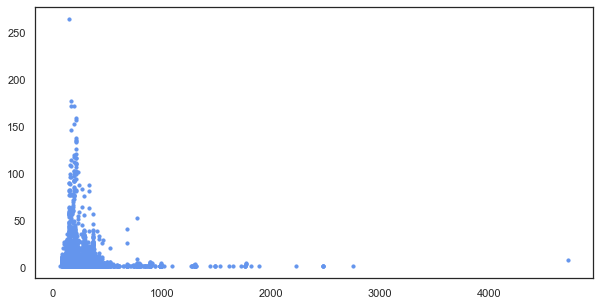

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(mpstats['price'],
            mpstats['sales_num'],
            s=10, c='#6495ED')

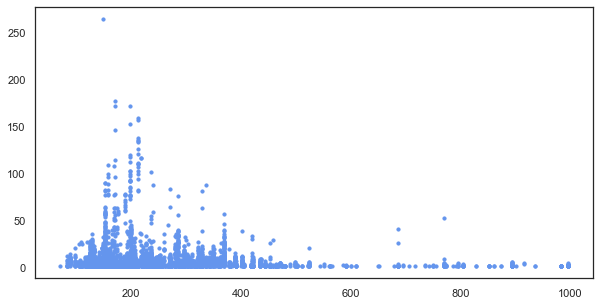

In [61]:
plt.figure(figsize=(10,5))
plt.scatter(mpstats[mpstats['price'] < 1000]['price'],
            mpstats[mpstats['price'] < 1000]['sales_num'],
            s=10, c='#6495ED')

Определим оптимальное число кластеров.

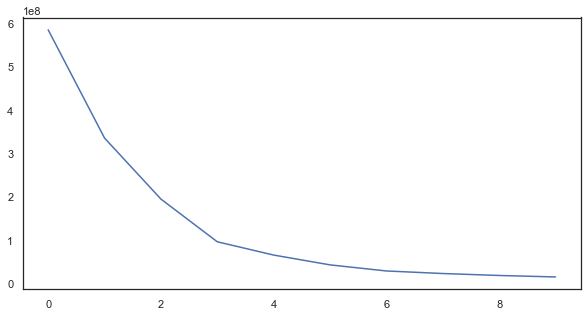

In [62]:
# the elbow method (справочно)
# sum of squared errors within cluster
def calculate_cluster_sse(series, kmax=10):
    sse = []
    points = series.to_numpy().reshape(-1, 1)
    for k in range(1, kmax+1):
        k_means = KMeans(n_clusters=k).fit(points)
        centroids = k_means.cluster_centers_
        pred_clusters = k_means.predict(points)
        df = pd.DataFrame({'price': series, 'cluster': pred_clusters})
        df = df.merge(pd.DataFrame(centroids), left_on='cluster', right_index=True)
        df = df.rename(columns={0: 'centre'})
        df['sse'] = (df['price'] - df['centre']) ** 2
        sse.append(df['sse'].sum())
    return sse

sse = calculate_cluster_sse(prices_exp['price'])
plt.plot([i for i in range(len(sse))], sse)
plt.show()

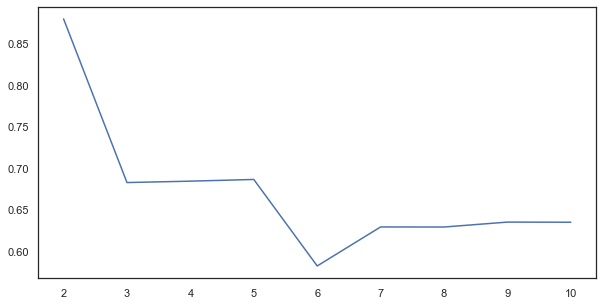

In [63]:
# the silhouette method
# the score reaches its global maximum at the optimal k
sil = []
kmax = 10
x = prices_exp['price'].to_numpy().reshape(-1, 1)
for k in range(2, kmax+1):
    k_means = KMeans(n_clusters=k).fit(x)
    labels = k_means.labels_
    sil.append(silhouette_score(x, labels, metric='euclidean'))
    
plt.plot([i+2 for i in range(len(sil))], sil)
plt.show()

In [67]:
k_opt = sil.index(max(sil)) + 2
k_opt

2

In [81]:
k_means = KMeans(n_clusters=k_opt).fit(x)
pred_clusters = k_means.predict(x)
centroids = k_means.cluster_centers_
centres = list()
for c in centroids:
    centres.append(*c)
        
prices_clusters = pd.DataFrame({'cluster': [i for i in range(len(centres))], 'cluster_centre': centres})
prices_clusters['cluster_centre'] = round(prices_clusters['cluster_centre'],-1)
prices_clusters

,cluster,cluster_centre
0,0,990.0
1,1,220.0


In [69]:
prices_exp['cluster'] = pred_clusters
prices_exp

,index,price,cluster
0,0,995,1
1,1,285,0
2,1,285,0
3,1,285,0
4,1,285,0
...,...,...,...
31938,4288,161,0
31939,4289,149,0
31940,4289,149,0
31941,4289,149,0


In [82]:
clusters_borders = pd.DataFrame()
for i in prices_clusters['cluster'].to_list():
    left_border = prices_exp[prices_exp['cluster'] == i]['price'].min()
    right_border = prices_exp[prices_exp['cluster'] == i]['price'].max()
    cluster = {'cluster': i,
              'left_border': int(round(left_border, -1)),
              'right_border': int(round(right_border, -1))}
    clusters_borders = clusters_borders.append(cluster, ignore_index=True)
prices_clusters = prices_clusters.merge(clusters_borders, on='cluster')
# prices_clusters['price_interval'] = prices_clusters['left_border'].astype(str) + '-' \
#                                     + prices_clusters['right_border'].astype(str)
prices_clusters

,cluster,cluster_centre,left_border,right_border,price_interval
0,0,990.0,70.0,600.0,70.0-600.0
1,1,220.0,610.0,4720.0,610.0-4720.0


In [ ]:
prices_exp = prices_exp.drop_duplicates().reset_index(drop=True)
prices_exp = prices_exp.drop(['index','price'], axis=1)
prices_exp

In [38]:
mpstats = mpstats.merge(prices_exp, left_index=True, right_index=True)
mpstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4290 entries, 0 to 4289
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     4290 non-null   object
 1   name           4290 non-null   object
 2   brand          4290 non-null   object
 3   category_init  4290 non-null   object
 4   comments       4290 non-null   int64 
 5   rating         4290 non-null   int64 
 6   price          4290 non-null   int64 
 7   sales_num      4290 non-null   int64 
 8   date           4290 non-null   object
 9   category       4290 non-null   object
 10  subject        4290 non-null   object
 11  sales_vol      4290 non-null   int64 
 12  cluster        4290 non-null   int32 
dtypes: int32(1), int64(5), object(7)
memory usage: 419.1+ KB


In [39]:
def sales_history_stats(df):
    '''
    Calculates statistics on sales history, 
    returns new dataframe
    '''
    delta = df['date'].max() - df['date'].min()
    days = int(delta.days)
    values = list(df['sales_num'])
    earnings = list(df['sales_vol'])
    prices = list(df['price'])
    sold_count = sum(values)
    sold_vol = sum(earnings)
 
    if len(values) < days:
        values.extend([0] * (len(values) - days))
        earnings.extend([0] * (len(earnings) - days))
 
    res = pd.Series([sold_count,
                     np.mean(values),
                     sold_vol,
                     np.std(values),
                     np.mean(earnings),
                     np.std(earnings),
                     np.mean(prices)],
                     index=['sold',
                            'sold_daily',
                            'sales_vol',
                            'sold_std',
                            'daily_earnings',
                            'daily_earnings_std',
                            'avg_price'])
    return round(res, 2)

In [40]:
clusters = mpstats[['product_id','cluster']].groupby(['product_id']).agg(lambda x: pd.Series.mode(x)[0])
clusters['cluster'] = clusters['cluster'].astype(int)
clusters = clusters.reset_index()
clusters

,product_id,cluster
0,10152685,0
1,10725065,0
2,11117570,1
3,11470068,0
4,11470070,0
...,...,...
91,8500790,0
92,8580225,0
93,8981019,0
94,9748712,0


In [41]:
# аналитика по продуктам
mpstats_product = mpstats.groupby(['brand','product_id']).apply(sales_history_stats).reset_index()
mpstats_product['market_share'] = round(mpstats_product['sales_vol'] / mpstats_product['sales_vol'].sum() * 100, 2)
mpstats_product = mpstats_product.sort_values(by=['market_share'], ascending=False).reset_index(drop=True)
mpstats_product['share_cum'] = mpstats_product['market_share'].cumsum()

mpstats_product = mpstats_product.merge(clusters, on=['product_id'])
mpstats_product = mpstats_product.merge(prices_clusters, on=['cluster'])
mpstats_product = mpstats_product.merge(rating, on=['brand','product_id'])
mpstats_product = mpstats_product.merge(categories, on=['product_id'])
mpstats_product = mpstats_product.merge(start_dates[['product_id','sales_period']], on=['product_id'])
mpstats_product = mpstats_product[['brand',
                                   'product_id',
                                   'market_share',
                                   'share_cum',
                                   'sold',
                                   'sold_daily',
                                   'sales_vol',
                                   'daily_earnings',
                                   'avg_price',
                                   'cluster',
                                   'cluster_centre',
                                   'comments',
                                   'rating',
                                   'categories',
                                   'sales_period']]
mpstats_product['brand'] = [x.replace(' ','\xa0') for x in mpstats_product['brand']]
mpstats_product.head(10)

,brand,product_id,market_share,share_cum,sold,sold_daily,sales_vol,daily_earnings,avg_price,cluster,cluster_centre,comments,rating,categories,sales_period
0,essence,11669880,20.05,20.05,7009.0,62.03,1480560.0,13102.30,225.65,0,220.0,469,5,1,>6m
1,NYX PROFESSIONAL MAKEUP,8104711,8.36,28.41,1631.0,11.99,617133.0,4537.74,390.02,0,220.0,287,4,1,>6m
2,Cafe mimi,10152685,7.79,36.20,3718.0,35.75,575016.0,5529.00,152.08,0,220.0,303,5,2,>6m
3,SINICHKA,15049255,6.74,42.94,1499.0,11.36,498126.0,3773.68,341.33,0,220.0,117,5,2,>6m
4,СпивакЪ,7893017,6.58,49.52,2545.0,16.31,486244.0,3116.95,201.42,0,220.0,279,5,1,>6m
5,Vivienne Sabo,14253795,4.00,53.52,933.0,7.02,295609.0,2222.62,360.77,0,220.0,56,4,1,>6m
6,mi&ko,8580225,3.89,57.41,923.0,7.76,287590.0,2416.72,314.34,0,220.0,104,4,3,>6m
7,СпивакЪ,7893016,3.65,61.06,1322.0,8.70,269764.0,1774.76,205.32,0,220.0,226,4,1,>6m
8,Витэкс,9908847,2.77,63.83,1285.0,9.88,204221.0,1570.93,164.45,0,220.0,199,4,1,>6m
9,ariBeauty,37318734,2.57,66.40,607.0,7.49,189716.0,2342.17,304.42,0,220.0,60,5,1,>6m


*market_share* - доля рынка, %  
*share_cum* - доля рынка накопленная, %  
*sold* - объем продаж, шт.  
*sold_daily* - среднесуточный объем продаж, шт.  
*sales_vol* - объем продаж, руб.  
*daily_earnings* - среднесуточный объем продаж, руб.  
*avg_price* - средняя цена продажи, руб.   
*cluster* - ценовой кластер продукта  
*cluster_centre* - средневзвешенная цена ценового сегмента продукта (справочно), руб.  
*comments* - количество отзывов, шт. (на текущую дату)  
*rating* - рейтинг продукта (на текущую дату)  
*categories* - число категорий, в которых представлен продукт  
*sales_period* - период продаж, мес.

In [87]:
for i in prices_clusters['cluster'].to_list():
    print(i,
          mpstats_product[mpstats_product['cluster'] == i]['avg_price'].min(),
          mpstats_product[mpstats_product['cluster'] == i]['avg_price'].max())

0 84.44 749.62
1 647.88 2426.82


In [42]:
# аналитика по брендам
mpstats_brand = mpstats.groupby(['brand']).apply(sales_history_stats).reset_index()
mpstats_brand['market_share'] = round(mpstats_brand['sales_vol'] / mpstats_brand['sales_vol'].sum() * 100, 2)
mpstats_brand = mpstats_brand.sort_values(by=['market_share'], ascending=False)
mpstats_brand['share_cum'] = mpstats_brand['market_share'].cumsum()
mpstats_brand['brand'] = [x.replace(' ','\xa0') for x in mpstats_brand['brand']]
mpstats_brand = mpstats_brand.merge(
                        mpstats_product[['brand','product_id','rating']].groupby(['brand']).agg(
                        products = pd.NamedAgg('product_id', 'count')).reset_index(),
                        how='left', on='brand')
mpstats_brand = mpstats_brand[['brand',
                               'market_share',
                               'share_cum',
                               'sold',
                               'sold_daily',
                               'sales_vol',
                               'daily_earnings',
                               'avg_price',
                               'products']]

# for col in mpstats_brand.columns:
#     mpstats_brand[col] = ['{0:,}'.format(x).replace(',', '\xa0') \
#                           if isinstance(x, (float, int)) and x >= 1000 \
#                           else x for x in mpstats_brand[col]]

# for col in mpstats_brand.columns:
#     if col not in ['products']:
#         mpstats_brand[col] = ['{:.2f}'.format(x) \
#                                 if isinstance(x, (float, int)) \
#                                 else x for x in mpstats_brand[col]]

mpstats_brand.head(10)

,brand,market_share,share_cum,sold,sold_daily,sales_vol,daily_earnings,avg_price,products
0,essence,20.05,20.05,7009.0,62.03,1480560.0,13102.30,225.65,1
1,СпивакЪ,11.72,31.77,4442.0,9.98,865752.0,1945.51,203.70,3
2,Cafe mimi,10.76,42.53,4527.0,14.70,794671.0,2580.10,231.02,4
3,NYX PROFESSIONAL MAKEUP,8.36,50.89,1631.0,11.99,617133.0,4537.74,390.02,1
4,SINICHKA,6.74,57.63,1499.0,11.36,498126.0,3773.68,341.33,1
5,Vivienne Sabo,4.00,61.63,933.0,7.02,295609.0,2222.62,360.77,1
6,mi&ko,3.91,65.54,927.0,7.60,288886.0,2367.92,314.49,2
7,Витэкс,3.23,68.77,1476.0,6.71,238199.0,1082.72,173.21,3
8,Pretty Garden,2.69,71.46,1074.0,4.61,198444.0,851.69,186.83,4
9,ariBeauty,2.57,74.03,607.0,7.49,189716.0,2342.17,304.42,1


In [43]:
# степень монополизации рынка
# индекс Херфиндаля-Хиршмана
shares = mpstats_brand['market_share'].to_list()
ihh = sum([(x/100)**2 for x in shares])
print(f'Степень монополизации рынка - {round(ihh*100,1)}%')

if ihh <= 0.1:
    print('--> Неконцентрированный рынок')
elif 0.1 < ihh <= 0.18:
    print('--> Умеренно концентрированный рынок')
else:
    print('--> Высококонцентрированный рынок')

Степень монополизации рынка - 8.6%
--> Неконцентрированный рынок


In [ ]:
#  деление рынка по брендам, визуализация
n = 16
brand_barplot = mpstats_brand[['brand','market_share']]
brand_barplot['labels'] = [x.lower() \
                           if x in brand_barplot['brand'].head(n).to_list() \
                           else 'other' for x in brand_barplot['brand']]
brand_barplot = brand_barplot.groupby(['labels']).sum().reset_index().sort_values(by='market_share',ascending=False)
brand_barplot['labels'] = [x.lower() if len(x) <= 10 else x[:10]+'...' for x in brand_barplot['labels']]
other = brand_barplot[brand_barplot['labels'] == 'other']
brand_barplot = brand_barplot[brand_barplot['labels'] != 'other']
brand_barplot = pd.concat([brand_barplot,other], axis=0).reset_index(drop=True)

other = mpstats_brand[['brand','market_share']]
other['labels'] = [x.lower() if len(x) <= 10 else x[:10]+'...' for x in other['brand']]
other['labels'] = [x.lower() if x not in other['labels'].head(n).to_list() else None for x in other['labels']]
other = other.dropna(axis=0).head(n)

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(brand_barplot)+15)[12:]] 

sns.set(rc={'figure.figsize':(10,12)})
sns.set_theme(style="white")

fig, ax = plt.subplots(2,1)
p1 = sns.barplot(x='labels',
                y='market_share',
                data=brand_barplot,
                palette=colors,
                dodge=False,
                ax=ax[0])
for item in p1.get_xticklabels():
    item.set_rotation(45)
    
if not other.empty:
    p2 = sns.barplot(x='labels',
                    y='market_share',
                    data=other,
                    palette=colors,
                    dodge=False,
                    ax=ax[1])
    for item in p2.get_xticklabels():
        item.set_rotation(45)
    
sns.despine()

In [45]:
# ценовые сегменты, визуализация
barplot_df = prices_clusters.merge(mpstats_product[['cluster',
                                                    'product_id',
                                                    'sold',
                                                    'sales_vol']].groupby(['cluster']).agg(
    products = pd.NamedAgg('product_id', 'count'),  # число продуктов в ценовом кластере, шт.
    sold = pd.NamedAgg('sold', 'sum'),  # количество продаж в ценовом кластере, шт.
    sales_vol = pd.NamedAgg('sales_vol', 'sum')  # объем продаж в ценовом кластере, руб.
    ).reset_index(), how='left', on='cluster')
barplot_df = barplot_df[['cluster',
                         'cluster_centre',
                         'products',
                         'sold',
                         'sales_vol']]
barplot_df = barplot_df.fillna(0)
barplot_df['cluster_centre'] = barplot_df['cluster_centre'].astype(str)
barplot_df

,cluster,cluster_centre,products,sold,sales_vol
0,0,220.0,86,31524.0,6973511.0
1,1,990.0,10,419.0,412170.0


In [ ]:
# ценовые сегменты, визуализация
sns.set(rc={'figure.figsize':(8,17)})
sns.set_theme(style="white")
fig, ax = plt.subplots(3,1)

p1 = sns.barplot(x='products',
                 y='cluster_centre',
                 data=barplot_df,
                 orient='h',
                 palette=colors,
                 dodge=False,
                 ax=ax[0],
                 log=False)
p1.grid()

p2 = sns.barplot(x='sold',
                 y='cluster_centre',
                 data=barplot_df,
                 orient='h',
                 palette=colors,
                 dodge=False,
                 ax=ax[1],
                 log=False)
p2.grid()

p3 = sns.barplot(x='sales_vol',
                 y='cluster_centre',
                 data=barplot_df,
                 orient='h',
                 palette=colors,
                 dodge=False,
                 ax=ax[2],
                 log=False)
p3.grid()

sns.despine()

In [49]:
# доп. сведения по ценам
price_mean = mpstats['price'].mean()  # среднее значение цены
price_median = mpstats['price'].median()  # медианное значение цены
price_std = mpstats['price'].std()  # стандартное отклонение (справочно)

print('mean', '\t', round(price_mean,1))
print('median', '\t', round(price_median,1))
print('stdev', '\t', round(price_std,1))

mean 	 275.5
median 	 220.0
stdev 	 224.7


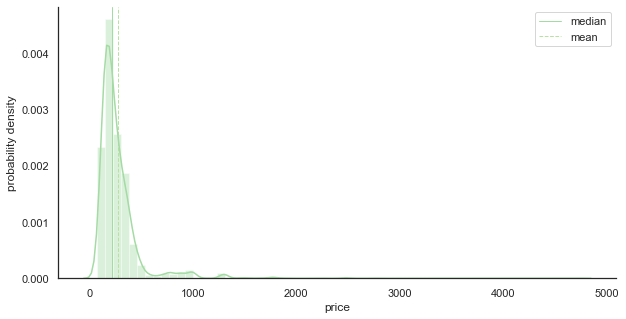

In [50]:
# визуализация параметрического распределения
# гистограмма + график плотности распределения
sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="white", palette=colors[10:])
plt.axvline(price_median,  # медианное значение цены
            linewidth=1,
            color=colors[10],
            linestyle='-',
            label="median")
plt.axvline(price_mean,  # среднее значение цены
            linewidth=1,
            color=colors[9],
            linestyle='--',
            label="mean")
p = sns.distplot(mpstats['price'], bins=60)
p.set_xlabel("price", fontsize=12)
p.set_ylabel("probability density", fontsize=12)
sns.despine()
plt.legend()

In [89]:
def round_50(x):
    return round(x * 2, -2) // 2

In [ ]:
sales_bars = mpstats[['price','sales_vol']]
# sales_bars['price'] = round(sales_bars['price'], -2)
sales_bars['price'] = [round_50(x) for x in sales_bars['price']]
sales_bars = sales_bars.groupby(['price']).sum().reset_index()

sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme(style="white")
barplot = sns.barplot(x='price',
                      y='sales_vol',
                      data=sales_bars,
                      dodge=False,
                      log=False)
for item in barplot.get_xticklabels():
    item.set_rotation(40)
sns.despine()